In [1]:
import pandas as pd
import plotly.express as px

# Chargement du CSV
df = pd.read_csv("loyers.csv", sep=';', encoding='utf-8')

# Extraction des coordonnées GPS
df[['lat', 'lon']] = df['geo_point_2d'].str.split(',', expand=True)
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

# Nettoyage
df = df.dropna(subset=['lat', 'lon', 'Loyers de référence', 'Année'])
df['Année'] = df['Année'].astype(int)
df = df.sort_values(by='Année')

# Moyenne par point et année (si besoin)
df_mean = df.groupby(['Année', 'lat', 'lon'], as_index=False)['Loyers de référence'].mean()

# Carte interactive avec échelle fixée
fig = px.scatter_mapbox(
    df_mean,
    lat="lat",
    lon="lon",
    color="Loyers de référence",
    size="Loyers de référence",
    animation_frame="Année",
    color_continuous_scale="RdYlGn_r",  # vert → jaune → rouge
    range_color=[15, 40],               # fixe l’échelle entre 15 et 40 €/m²
    size_max=15,
    zoom=11,
    mapbox_style="carto-positron",
    title="Évolution du loyer moyen par localisation et par année (€/m²)"
)

fig.show()

Création de la colonne "Arrondissement"

In [5]:


# Vérification de la colonne Numéro INSEE
if "Numéro INSEE du quartier" in df.columns:
    # Extraction des 4e et 5e caractères
    df['Arrondissement'] = df['Numéro INSEE du quartier'].astype(str).str[3:5]
    
    # Conversion en entier (supprime les zéros devant, ex : "03" → 3)
    df['Arrondissement'] = df['Arrondissement'].astype(int)
else:
    print("⚠️ La colonne 'Numéro INSEE du quartier' n'a pas été trouvée dans le fichier.")

# Vérification du résultat
print("Exemple d'arrondissements extraits :")
print(df[['Numéro INSEE du quartier', 'Arrondissement']].head())


Exemple d'arrondissements extraits :
   Numéro INSEE du quartier  Arrondissement
0                   7511039              10
1                   7511247              12
2                   7510934               9
3                   7510623               6
4                   7511662              16


In [12]:
import pandas as pd
import re

# --- 1) Charger les données (ou utiliser df existant) ---
df = pd.read_csv("loyers.csv", sep=';', encoding='utf-8')  # adapte si besoin

# --- 2) Retrouver la colonne INSEE du quartier, même si le nom varie ---
def normalize(s: str) -> str:
    """minuscule, sans accents, espaces compressés"""
    import unicodedata
    s2 = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    s2 = re.sub(r'\s+', ' ', s2.strip().lower())
    return s2

cols_norm = {normalize(c): c for c in df.columns}
candidates = [
    "numero insee du quartier",
    "numéro insee du quartier",
    "code insee du quartier",
    "code insee quartier",
    "insee_quartier",
    "insee quartier",
]

insee_col = None
for cand in candidates:
    if cand in cols_norm:
        insee_col = cols_norm[cand]
        break

if insee_col is None:
    raise ValueError(
        f"Impossible de trouver la colonne INSEE du quartier. Colonnes dispos:\n{list(df.columns)}"
    )

# --- 3) Créer la colonne Arrondissement à partir du code INSEE du quartier ---
# Paris: code commune sur 3 chiffres (101..120). Arrondissement = 2 derniers chiffres de ce bloc => globalement 2 derniers chiffres du code.
def extract_arrondissement(x):
    if pd.isna(x):
        return pd.NA
    s = str(x).strip()
    # garder uniquement les chiffres
    s = ''.join(ch for ch in s if ch.isdigit())
    if len(s) < 2:
        return pd.NA
    return int(s[-2:])  # deux derniers chiffres

df["Arrondissement"] = df[insee_col].apply(extract_arrondissement)

# Optionnel: filtrer les valeurs aberrantes (1..20 à Paris)
df = df[df["Arrondissement"].between(1, 20)]

# --- 4) Vérifier ---
print("Extrait depuis :", insee_col)
print(df[[insee_col, "Arrondissement"]].head())


Extrait depuis : Numéro INSEE du quartier
    Numéro INSEE du quartier  Arrondissement
6                    7510101               1
8                    7510413              13
14                   7510416              16
15                   7510416              16
19                   7510205               5


In [13]:
import plotly.express as px

# S'assurer que la colonne loyer existe
loyer_col = "Loyers de référence"  # adapte si ton libellé diffère
if loyer_col not in df.columns:
    raise ValueError(f"Colonne loyer introuvable : {loyer_col}. Colonnes: {list(df.columns)}")

df_clean = df.dropna(subset=["Arrondissement", loyer_col])
loyers_par_arr = (
    df_clean.groupby("Arrondissement")[loyer_col]
    .mean()
    .reset_index()
    .sort_values("Arrondissement")
)

fig = px.bar(
    loyers_par_arr,
    x="Arrondissement",
    y=loyer_col,
    color=loyer_col,
    color_continuous_scale="RdYlGn_r",
    title="Loyer moyen par arrondissement (€ / m²)",
    labels={loyer_col: "€/m²"},
)
fig.update_layout(template="plotly_white", coloraxis_colorbar=dict(title="€/m²"))
fig.show()


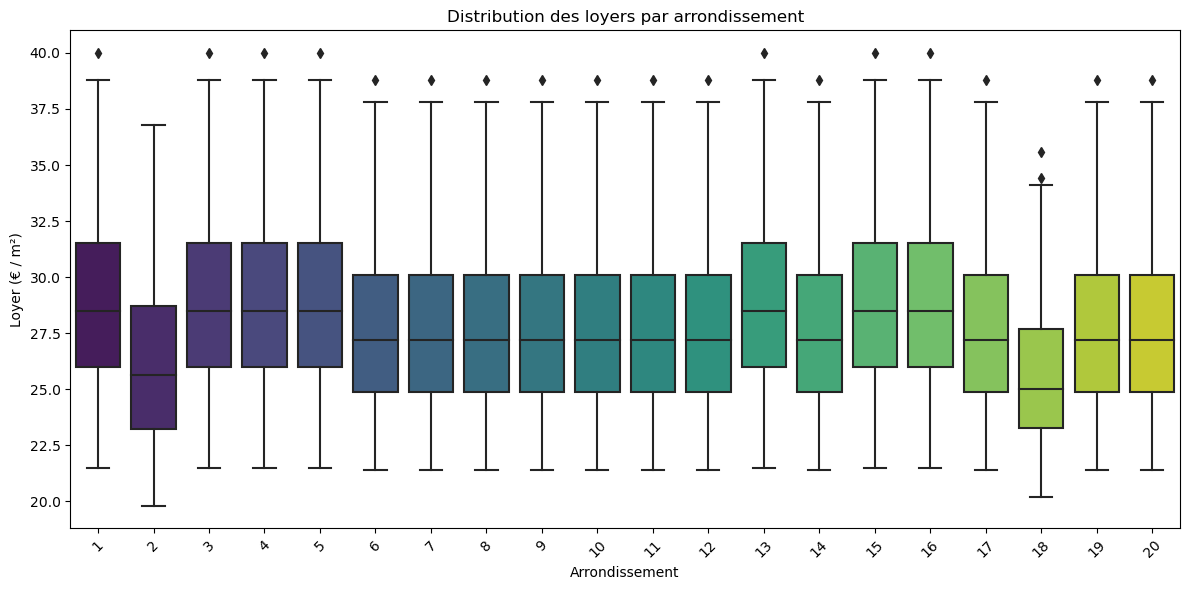

In [15]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Arrondissement', y='Loyers de référence', palette='viridis')
plt.title("Distribution des loyers par arrondissement")
plt.xlabel("Arrondissement")
plt.ylabel("Loyer (€ / m²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



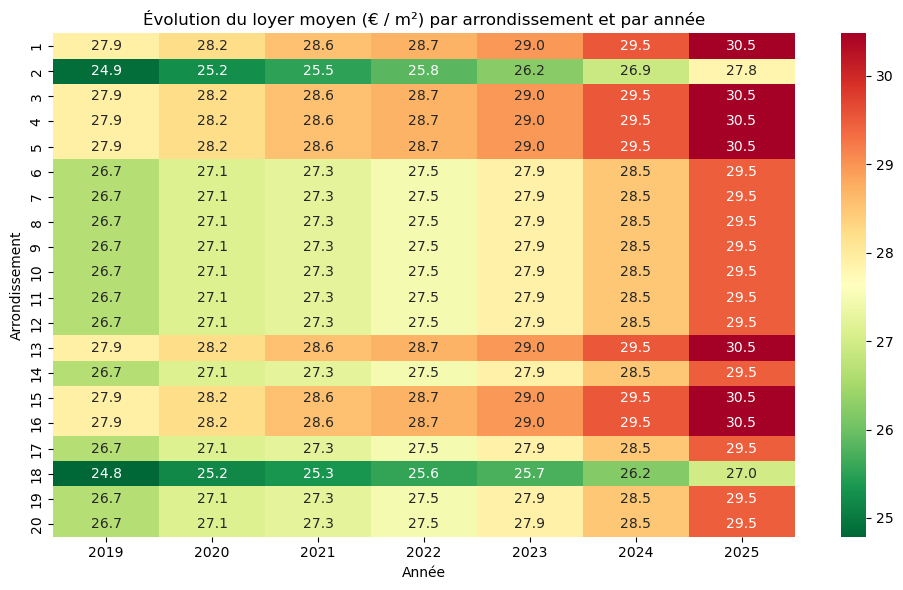

In [16]:
# Tableau croisé (année en colonne, arrondissement en ligne)
heatmap_data = df.pivot_table(
    values='Loyers de référence',
    index='Arrondissement',
    columns='Année',
    aggfunc='mean'
)

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, cmap="RdYlGn_r", annot=True, fmt=".1f")
plt.title("Évolution du loyer moyen (€ / m²) par arrondissement et par année")
plt.xlabel("Année")
plt.ylabel("Arrondissement")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Chargement du fichier
df = pd.read_csv("loyers_nettoye.csv", sep=';', encoding='utf-8')

# Création / vérification de la colonne Arrondissement
if "Arrondissement" not in df.columns and "Numéro INSEE du quartier" in df.columns:
    df["Arrondissement"] = df["Numéro INSEE du quartier"].astype(str).str[-2:].astype(int)

df = df.dropna(subset=["Arrondissement", "Loyers de référence"])

# Création du nuage de points interactif
fig = px.scatter(
    df,
    x="Arrondissement",
    y="Loyers de référence",
    color="Année",  # facultatif : pour voir l’évolution temporelle
    hover_data=["Année", "Loyers de référence"],
    title="📈 Nuage de points : Loyer au m² par arrondissement",
    labels={"Loyers de référence": "Loyer (€ / m²)"},
    color_continuous_scale="Viridis"
)

fig.update_traces(marker=dict(size=6, opacity=0.6))
fig.update_layout(template="plotly_white")
fig.show()


In [26]:
import pandas as pd
import plotly.express as px

# Chargement du fichier
df = pd.read_csv("loyers_nettoye.csv", sep=';', encoding='utf-8')

# Vérification de la colonne INSEE
if "Numéro INSEE du quartier" in df.columns:
    # Extraction des chiffres du code INSEE
    df["Numéro INSEE du quartier"] = df["Numéro INSEE du quartier"].astype(str).str.extract(r"(\d+)")
    
    # Création de la colonne Arrondissement à partir du code INSEE (ex: 75101 -> 1)
    df["Arrondissement"] = df["Numéro INSEE du quartier"].astype(str).apply(
        lambda x: int(x[-2:]) if x.startswith("751") else None  # uniquement Paris (code 751)
    )

# Filtrer uniquement les arrondissements 1 à 20
df = df[(df["Arrondissement"] >= 1) & (df["Arrondissement"] <= 20)]

# Nettoyage : suppression des lignes incomplètes
df = df.dropna(subset=["Arrondissement", "Loyers de référence", "Année"])

# Création du nuage de points interactif
fig = px.scatter(
    df,
    x="Arrondissement",
    y="Loyers de référence",
    color="Année",
    hover_data=["Année", "Loyers de référence"],
    title="📈 Nuage de points : Loyer au m² par arrondissement (Paris uniquement)",
    labels={"Loyers de référence": "Loyer (€ / m²)", "Arrondissement": "Arrondissement (1–20)"},
    color_continuous_scale="Viridis"
)

# Configuration du style
fig.update_traces(marker=dict(size=6, opacity=0.6))
fig.update_layout(
    template="plotly_white",
    xaxis=dict(
        tickmode='linear',  # force les ticks à être linéaires
        tick0=1,
        dtick=1,
        range=[0.5, 20.5],  # pour encadrer joliment les arrondissements
    )
)

fig.show()


In [29]:
import itertools
import numpy as np

# Base moyenne
evo = df.groupby(['Année', 'Arrondissement'])['Loyers de référence'].mean().reset_index()

# Ajouter les combinaisons manquantes (toutes les années x 1–20)
annees = sorted(df['Année'].unique())
arrs = list(range(1, 21))
full = pd.DataFrame(list(itertools.product(annees, arrs)), columns=['Année', 'Arrondissement'])

# Fusion pour avoir toutes les combinaisons
evo_complet = full.merge(evo, on=['Année', 'Arrondissement'], how='left')

# Graphique complet
fig = px.line(
    evo_complet,
    x='Année',
    y='Loyers de référence',
    color='Arrondissement',
    markers=True,
    title="📈 Évolution du loyer moyen par arrondissement (€/m²)"
)
fig.update_layout(template='plotly_white')
fig.show()


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_58856\3549990157.py:7: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.

c:\Users\Utilisateur\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.



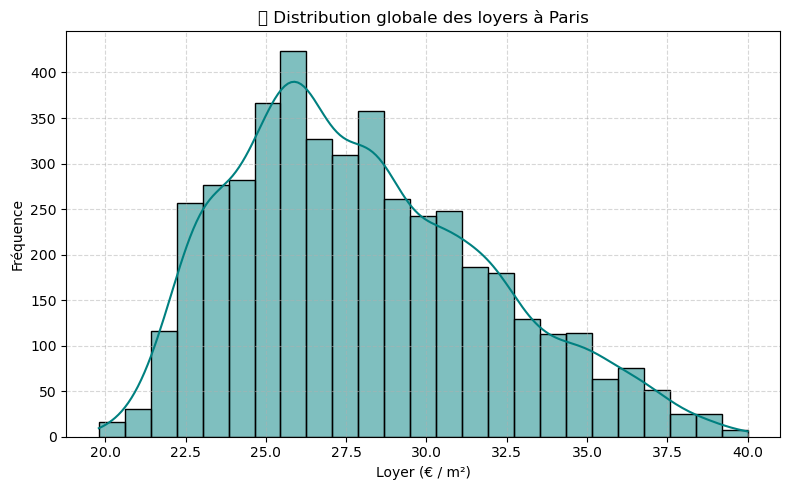

In [32]:
plt.figure(figsize=(8,5))
sns.histplot(df['Loyers de référence'], bins=25, color='teal', kde=True)
plt.title("📊 Distribution globale des loyers à Paris")
plt.xlabel("Loyer (€ / m²)")
plt.ylabel("Fréquence")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [33]:
import geopandas as gpd

# Si tu as un GeoJSON des arrondissements de Paris :
geojson_url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/exports/geojson"

fig = px.choropleth_mapbox(
    loyer_par_arr,
    geojson=geojson_url,
    locations='Arrondissement',
    featureidkey='properties.c_ar',
    color='Loyers de référence',
    color_continuous_scale='RdYlGn_r',
    mapbox_style='carto-positron',
    zoom=10,
    center={"lat": 48.8566, "lon": 2.3522},
    opacity=0.8,
    title="🗺️ Loyer moyen par arrondissement (carte de Paris)"
)
fig.show()


ModuleNotFoundError: No module named 'geopandas'

In [34]:
annees_compare = [2015, 2024]
df_sel = df[df['Année'].isin(annees_compare)]

fig = px.bar(
    df_sel.groupby(['Année', 'Arrondissement'])['Loyers de référence'].mean().reset_index(),
    x='Arrondissement',
    y='Loyers de référence',
    color='Année',
    barmode='group',
    color_discrete_sequence=px.colors.qualitative.Plotly,
    title="Comparaison des loyers par arrondissement : 2015 vs 2024"
)
fig.update_layout(template='plotly_white')
fig.show()
